In [1]:
!pip install kaggle --quiet

In [2]:
!kaggle datasets download ravitejauoh/cookie --quiet

Dataset URL: https://www.kaggle.com/datasets/ravitejauoh/cookie
License(s): unknown


In [3]:
!unzip -q cookie.zip

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import os
import matplotlib.pyplot as plt

In [5]:
#flatten the dataset
import os
import shutil

source_dir = "/content/kaggledataset"
destination_dir = "/content/flattened_cookie"

os.makedirs(destination_dir, exist_ok=True)


for root, _, files in os.walk(source_dir):
    for file in files:
        source_path = os.path.join(root, file)
        destination_path = os.path.join(destination_dir, file)
        shutil.move(source_path, destination_path)

print(f"Files flattened from '{source_dir}' to '{destination_dir}'")


Files flattened from '/content/kaggledataset' to '/content/flattened_cookie'


## Gotta check the size of the images

In [6]:
from PIL import Image

dataset_dir = "/content/flattened_cookie"

image_sizes = {}

for filename in os.listdir(dataset_dir):
    if filename.endswith(('.jpg')):
        filepath = os.path.join(dataset_dir, filename)
        try:
            with Image.open(filepath) as img:
                width, height = img.size
                size_tuple = (width, height)
                if size_tuple in image_sizes:
                    image_sizes[size_tuple] +=1
                else:
                    image_sizes[size_tuple] = 1
        except Exception as e:
            print(f"Error processing image {filename}: {e}")


for size, count in image_sizes.items():
    print(f"Size {size}: {count} images")

Size (700, 645): 911 images


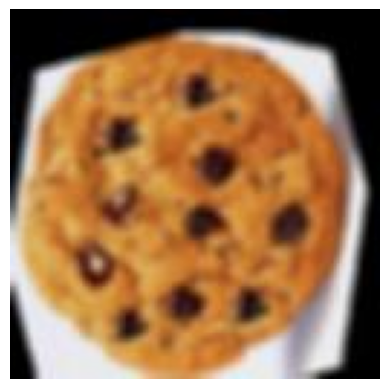

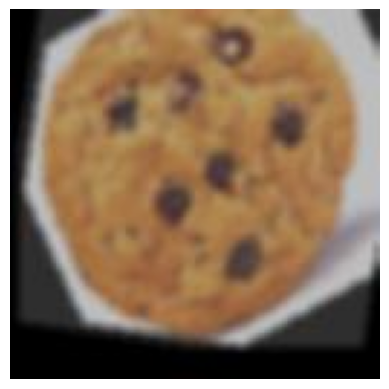

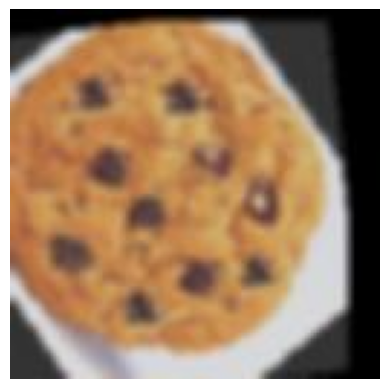

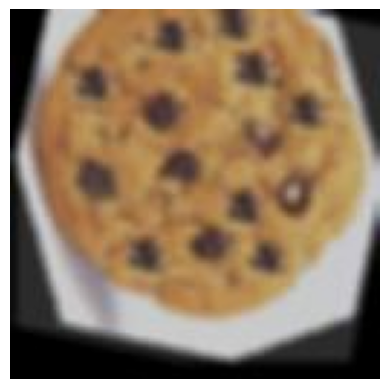

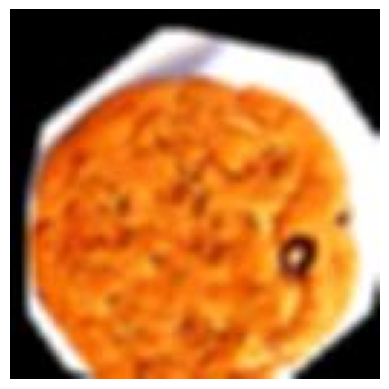

Processed 4555 images.


In [7]:
import os
import random
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import transforms

# Define the target size for resizing
target_size = (128, 128)
blur_radius = 2
num_augmentations_per_image = 5  # Number of augmented versions per image

# Specify the directory containing the images
dataset_dir = "/content/flattened_cookie"

# Create a directory to store the resized and augmented images
output_dir = "/content/resized_blurred_images"
os.makedirs(output_dir, exist_ok=True)

# Define the data augmentation pipeline (without elastic transformation)
augmentation_transforms = transforms.Compose([
    transforms.Resize(target_size),  # Resize the image
    transforms.RandomCrop(target_size, padding=4),  # Random crop with padding
    transforms.ColorJitter(brightness=0.1, contrast=0.6, saturation=0.1, hue=0.01),  # Reduced color jitter range
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(20),  # Random rotation within 20 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.GaussianBlur(kernel_size=5, sigma=blur_radius),  # Apply Gaussian Blur
])

# Function to apply the augmentation pipeline
def apply_augmentation(img):
    # Apply the default torchvision transformations
    img = augmentation_transforms(img)
    return img

# Iterate through the images in the directory
image_count = 0
for filename in os.listdir(dataset_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add more extensions if needed
        filepath = os.path.join(dataset_dir, filename)
        try:
            with Image.open(filepath) as img:
                # Apply the augmentation pipeline multiple times
                for i in range(num_augmentations_per_image):
                    augmented_img = apply_augmentation(img)

                    # Save the augmented image to the output directory
                    augmented_filename = f"{os.path.splitext(filename)[0]}_aug_{i}{os.path.splitext(filename)[1]}"
                    output_path = os.path.join(output_dir, augmented_filename)
                    augmented_img.save(output_path)

                    image_count += 1

        except Exception as e:
            print(f"Error processing image {filename}: {e}")

# Display the first 5 augmented images
for i in range(5):
    image_path = os.path.join(output_dir, os.listdir(output_dir)[i])  # Get the first 5 images
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()

print(f"Processed {image_count} images.")


In [8]:
# Create a directory to store the grayscale images
grayscale_dir = "/content/grayscale_images"
os.makedirs(grayscale_dir, exist_ok=True)

# Iterate through the resized and blurred images
for filename in os.listdir(output_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        filepath = os.path.join(output_dir, filename)
        try:
            with Image.open(filepath) as img:
                # Convert the image to grayscale
                grayscale_img = img.convert("L")

                # Save the grayscale image to the output directory
                output_path = os.path.join(grayscale_dir, filename)
                grayscale_img.save(output_path)

        except Exception as e:
            print(f"Error processing image {filename}: {e}")

In [27]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder for grayscale image
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),   # Output: 32 x H/2 x W/2
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout with a probability of 20%

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: 64 x H/4 x W/4
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout with a probability of 30%

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Output: 128 x H/8 x W/8
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.4),  # Dropout with a probability of 40%

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),  # Smaller latent space for reduced complexity
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout with a probability of 50%
        )

        # Decoder to reconstruct the color image
        self.decoder = nn.Sequential(
            nn.Linear(512, 128 * 16 * 16),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout with a probability of 50%
            nn.Unflatten(1, (128, 16, 16)),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 64 x H/4 x W/4
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.4),  # Dropout with a probability of 40%

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # Output: 32 x H/2 x W/2
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout with a probability of 30%

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),     # Output: 3 x H x W (RGB)
            nn.Sigmoid(),  # Output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [10]:
# Custom dataset to load grayscale and color images with the same name
class GrayscaleColorDataset(torch.utils.data.Dataset):
    def __init__(self, grayscale_dir, color_dir, transform=None):
        self.grayscale_dir = grayscale_dir
        self.color_dir = color_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(grayscale_dir))
        self.image_names = [name for name in self.image_names if name.endswith(".jpg")]  # Filter for .png files

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        grayscale_image_name = self.image_names[idx]
        color_image_name = grayscale_image_name  # Same name, different folder

        grayscale_image = Image.open(os.path.join(self.grayscale_dir, grayscale_image_name)).convert('L')
        color_image = Image.open(os.path.join(self.color_dir, color_image_name))

        if self.transform:
            grayscale_image = self.transform(grayscale_image)
            color_image = self.transform(color_image)

        return grayscale_image, color_image

Number of images in the dataset: 4555
Epoch [1/5], Loss: 0.0834
Epoch [2/5], Loss: 0.0413
Epoch [3/5], Loss: 0.0377
Epoch [4/5], Loss: 0.0360
Epoch [5/5], Loss: 0.0349
Average Test Loss: 0.0200


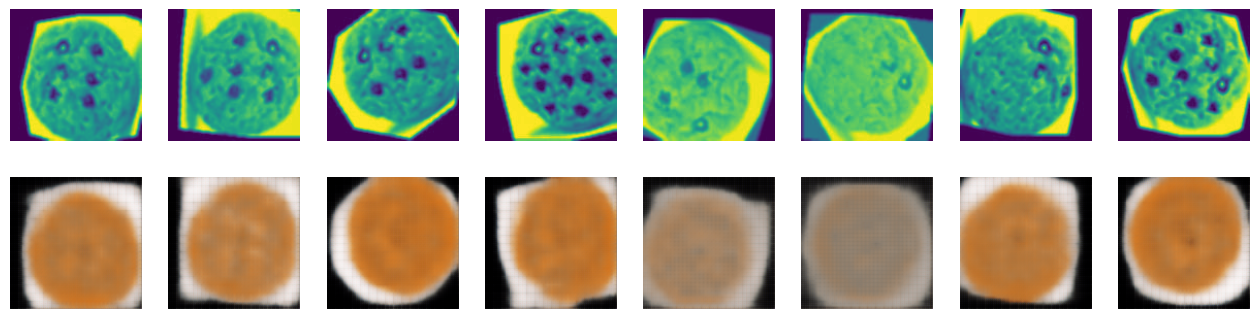

Training finished.


In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Initialize the dataset with grayscale and color images
grayscale_dir = '/content/grayscale_images'
color_dir = '/content/resized_blurred_images'

dataset = GrayscaleColorDataset(grayscale_dir, color_dir, transform=transform)

print(f"Number of images in the dataset: {len(dataset)}")
# Split data into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
color_model = ConvAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(color_model.parameters(), lr=0.001, weight_decay=1e-5)

# L1 regularization parameter
l1_lambda = 1e-7

# Training loop for the color autoencoder
num_epochs = 5
for epoch in range(num_epochs):
    color_model.train()
    running_loss = 0.0
    for grayscale_img, color_img in train_loader:
        grayscale_img = grayscale_img.to(device)
        color_img = color_img.to(device)

        # Pass grayscale image into the color autoencoder
        output = color_model(grayscale_img)

        # The target is the original color image
        reconstruction_loss = criterion(output, color_img)

        # L1 regularization
        l1_loss = sum(torch.sum(torch.abs(param)) for param in color_model.parameters())
        total_loss = reconstruction_loss + l1_lambda * l1_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Evaluation and Visualization
color_model.eval()  # Set to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for grayscale_img, color_img in test_loader:
        grayscale_img = grayscale_img.to(device)
        color_img = color_img.to(device)

        # Pass through the color autoencoder
        output = color_model(grayscale_img)

        # Calculate loss
        loss = criterion(output, color_img)
        test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f'Average Test Loss: {avg_test_loss:.4f}')

    # Visualize original vs. reconstructed color images
    batch_data, _ = next(iter(test_loader))
    batch_data = batch_data.to(device)

    reconstructed_batch = color_model(batch_data)

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(batch_data[i].cpu().numpy().transpose(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_batch[i].cpu().numpy().transpose(1, 2, 0))
        axes[1, i].axis('off')

    plt.show()

print("Training finished.")


In [11]:
def process_image(image_path,model):
    try:
        img = Image.open(image_path).convert("RGB")
        img = img.resize((128, 128))  # Resize

        # Grayscale conversion
        grayscale_img = img.convert("L")
        grayscale_img_tensor = transforms.ToTensor()(grayscale_img).unsqueeze(0).to(device)

        # Color autoencoder
        with torch.no_grad():
            color_output = model(grayscale_img_tensor)

        # Convert to PIL Image and save or display
        color_output = color_output.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        color_output = (color_output * 255).astype("uint8")
        color_output_image = Image.fromarray(color_output)

        return color_output_image

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

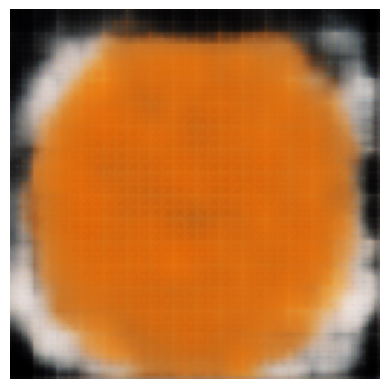

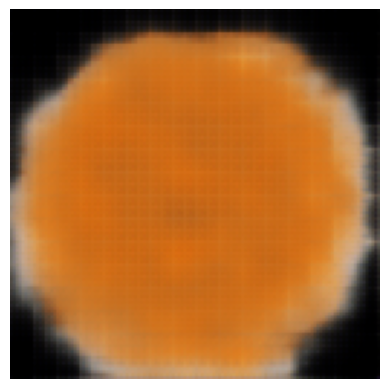

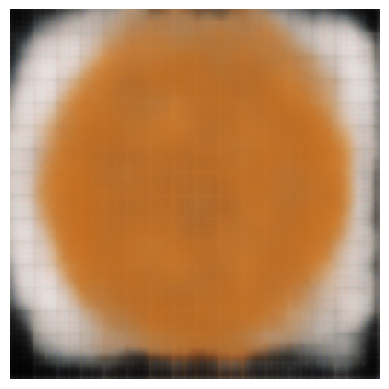

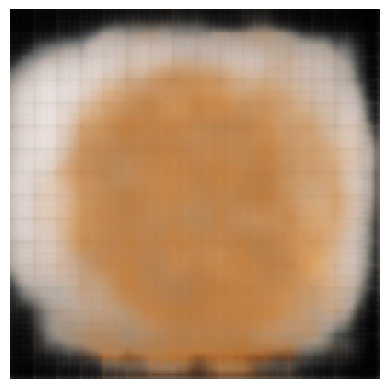

In [32]:
for img_path in ['car_wheel.jpg','america.png','pizza.png','india.png']:
  processed_image = process_image(img_path,color_model)

  if processed_image:
      processed_image.save(f"color_model_output_{img_path}") # Save the processed image
      plt.imshow(processed_image)
      plt.axis('off')
      plt.show()

In [14]:
torch.save(color_model.state_dict(), 'color_autoencoder.pth')

Trying out skip connections with no dropout and less layers

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SkipConnectionsAutoEncoder(nn.Module):
    def __init__(self):
        super(SkipConnectionsAutoEncoder, self).__init__()

        # Encoder for grayscale image (input: 1 channel)
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),   # Output: 32 x H/2 x W/2
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: 64 x H/4 x W/4
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Output: 128 x H/8 x W/8
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
        )

        # Bottleneck layer (latent space)
        self.bottleneck = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),  # Adjust according to the input size and downsampling
            nn.ReLU(),
        )

        # Decoder with skip connections
        self.dec1 = nn.Sequential(
            nn.Linear(512, 128 * 16 * 16),
            nn.ReLU(),
            nn.Unflatten(1, (128, 16, 16)),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 64 x H/4 x W/4
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # Output: 32 x H/2 x W/2
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),
        )
        self.dec4 = nn.Sequential(
            # Output layer for 3 channels (RGB color output)
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),     # Output: 3 x H x W (RGB)
            nn.Sigmoid(),  # Output between 0 and 1
        )

    def forward(self, x):
        # Encoder pass with skip connections
        enc1 = self.enc1(x)  # 32 x H/2 x W/2
        enc2 = self.enc2(enc1)  # 64 x H/4 x W/4
        enc3 = self.enc3(enc2)  # 128 x H/8 x W/8

        # Bottleneck pass
        bottleneck = self.bottleneck(enc3.flatten(start_dim=1))

        # Decoder pass with skip connections
        dec1 = self.dec1(bottleneck)  # 128 x H/8 x W/8
        dec2 = self.dec2(dec1)  # 64 x H/4 x W/4
        dec3 = self.dec3(dec2)  # 32 x H/2 x W/2
        output = self.dec4(dec3)  # 3 x H x W (RGB)

        return output

Number of images in the dataset: 4555
Epoch [1/5], Loss: 0.0613
Epoch [2/5], Loss: 0.0234
Epoch [3/5], Loss: 0.0197
Epoch [4/5], Loss: 0.0179
Epoch [5/5], Loss: 0.0167
Average Test Loss: 0.0132


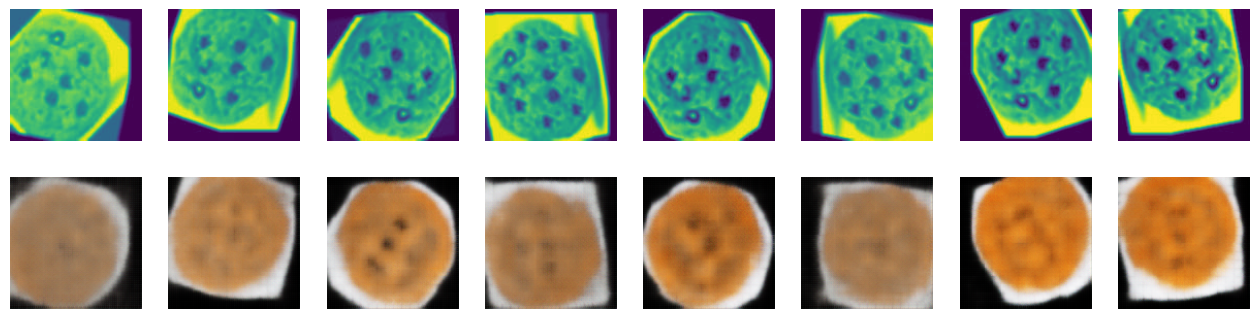

Training finished.


In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Initialize the dataset with grayscale and color images
grayscale_dir = '/content/grayscale_images'
color_dir = '/content/resized_blurred_images'

dataset = GrayscaleColorDataset(grayscale_dir, color_dir, transform=transform)

print(f"Number of images in the dataset: {len(dataset)}")
# Split data into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
skip_model = SkipConnectionsAutoEncoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(skip_model.parameters(), lr=0.001, weight_decay=1e-5)

# L1 regularization parameter
l1_lambda = 1e-7

# Training loop for the color autoencoder
num_epochs = 5
for epoch in range(num_epochs):
    skip_model.train()
    running_loss = 0.0
    for grayscale_img, color_img in train_loader:
        grayscale_img = grayscale_img.to(device)
        color_img = color_img.to(device)

        # Pass grayscale image into the skip autoencoder
        output = skip_model(grayscale_img)

        # The target is the original color image
        reconstruction_loss = criterion(output, color_img)

        # L1 regularization
        l1_loss = sum(torch.sum(torch.abs(param)) for param in skip_model.parameters())
        total_loss = reconstruction_loss + l1_lambda * l1_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Evaluation and Visualization
skip_model.eval()  # Set to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for grayscale_img, color_img in test_loader:
        grayscale_img = grayscale_img.to(device)
        color_img = color_img.to(device)

        # Pass through the skip autoencoder
        output = skip_model(grayscale_img)

        # Calculate loss
        loss = criterion(output, color_img)
        test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f'Average Test Loss: {avg_test_loss:.4f}')

    # Visualize original vs. reconstructed color images
    batch_data, _ = next(iter(test_loader))
    batch_data = batch_data.to(device)

    reconstructed_batch = skip_model(batch_data)

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(batch_data[i].cpu().numpy().transpose(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_batch[i].cpu().numpy().transpose(1, 2, 0))
        axes[1, i].axis('off')

    plt.show()

print("Training finished.")


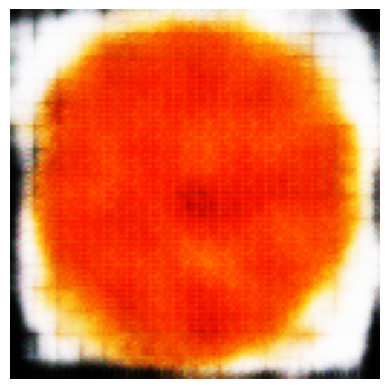

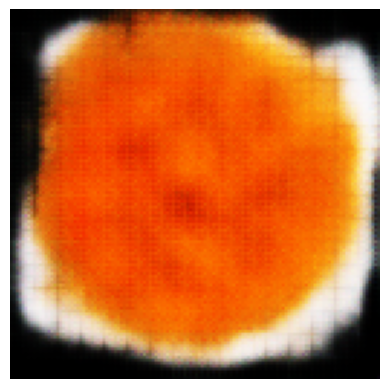

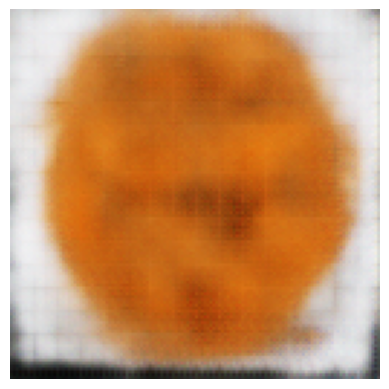

In [15]:
for img_path in ['car_wheel.jpg','america.png','pizza.png','india.png']:
  processed_image = process_image(img_path,skip_model)

  if processed_image:
      processed_image.save(f"output_{img_path}") # Save the processed image
      plt.imshow(processed_image)
      plt.axis('off')
      plt.show()

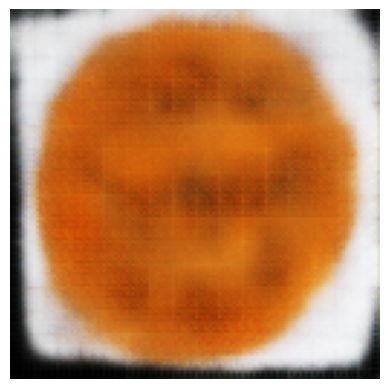

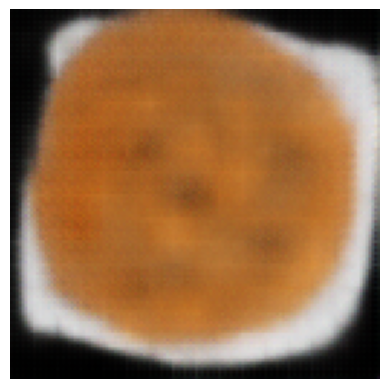

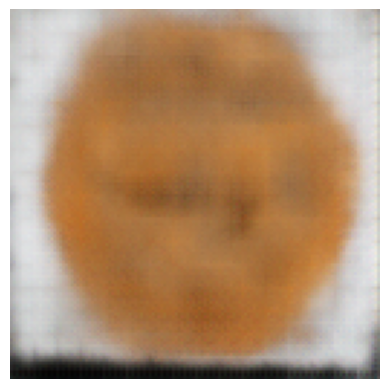

In [16]:
for img_path in ['output_car_wheel.jpg','output_america.png','output_pizza.png']:
  processed_image = process_image(img_path,skip_model)

  if processed_image:
      processed_image.save(f"output_{img_path}") # Save the processed image
      plt.imshow(processed_image)
      plt.axis('off')
      plt.show()

We can see that the cookie looks very blocky in the beginning and this is resolved by feeding through the model again. this makes me wanna think it is time to use an lstm

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class RecurrentAutoEncoder(nn.Module):
    def __init__(self):
        super(RecurrentAutoEncoder, self).__init__()

        # Encoder: Convolutional layers to extract spatial features
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)  # Output: 32 x H/2 x W/2
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # Output: 64 x H/4 x W/4
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: 128 x H/8 x W/8

        # Encoder RNN: Processes rows or columns as sequences
        self.encoder_rnn = nn.LSTM(input_size=128 * 16,  # Assuming H/8 = 16
                                   hidden_size=256,
                                   num_layers=1,
                                   batch_first=True)

        # Bottleneck to latent space
        self.bottleneck = nn.Linear(256, 512)  # Latent vector size

        # Decoder RNN: Reconstructs sequences
        self.decoder_rnn = nn.LSTM(input_size=512,
                                   hidden_size=256,
                                   num_layers=1,
                                   batch_first=True)

        # Map RNN outputs back to image channels
        self.rnn_to_img = nn.Linear(256, 128 * 16)  # Maps RNN output to (128 channels * width)

        # Decoder: Transpose convolutions to reconstruct spatial structure
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)  # Output: 64 x H/4 x W/4
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  # Output: 32 x H/2 x W/2
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)  # Output: 3 x H x W

    def forward(self, x):
        # Encoder: Extract spatial features
        x = F.relu(self.enc_conv1(x))  # 32 x H/2 x W/2
        x = F.relu(self.enc_conv2(x))  # 64 x H/4 x W/4
        x = F.relu(self.enc_conv3(x))  # 128 x H/8 x W/8

        # Prepare data for RNN: Reshape to (batch_size, sequence_length, features)
        batch_size, channels, height, width = x.size()
        x = x.permute(0, 2, 3, 1).reshape(batch_size, height, -1)  # Shape: (batch_size, H/8, 128 * W/8)

        # Encoder RNN
        _, (h_n, _) = self.encoder_rnn(x)  # h_n shape: (num_layers, batch_size, hidden_size)
        latent = self.bottleneck(h_n[-1])  # Take the final hidden state and map to latent space

        # Decoder RNN
        latent = latent.unsqueeze(1).repeat(1, height, 1)  # Repeat latent vector for each row/column
        rnn_out, _ = self.decoder_rnn(latent)  # Shape: (batch_size, sequence_length, hidden_size)

        # Map RNN output back to spatial dimensions
        rnn_out = self.rnn_to_img(rnn_out)  # Shape: (batch_size, sequence_length, 128 * W/8)
        rnn_out = rnn_out.reshape(batch_size, height, width, 128).permute(0, 3, 1, 2)  # Shape: (batch_size, 128, H/8, W/8)

        # Decoder: Reconstruct spatial resolution
        x = F.relu(self.dec_conv1(rnn_out))  # 64 x H/4 x W/4
        x = F.relu(self.dec_conv2(x))  # 32 x H/2 x W/2
        x = torch.sigmoid(self.dec_conv3(x))  # 3 x H x W (RGB)

        return x


Number of images in the dataset: 4555
Epoch [1/5], Loss: 0.0819
Epoch [2/5], Loss: 0.0646
Epoch [3/5], Loss: 0.0497
Epoch [4/5], Loss: 0.0412
Epoch [5/5], Loss: 0.0362
Average Test Loss: 0.0321


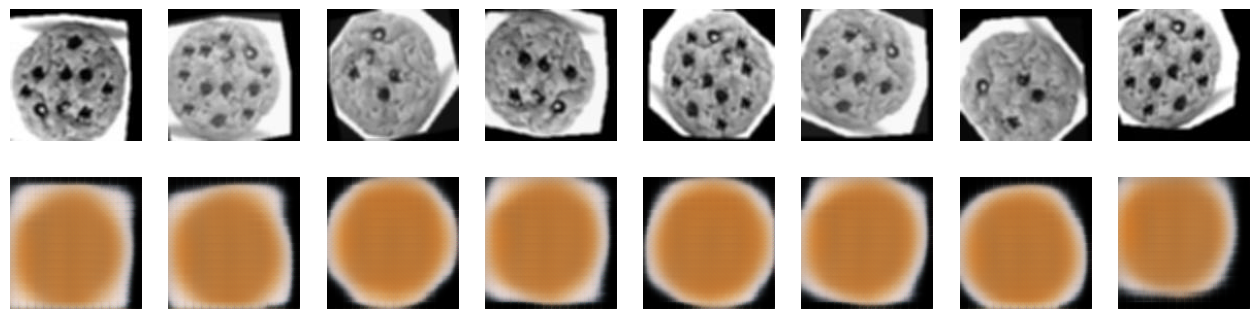

Training finished.


In [24]:

transform = transforms.Compose([
    transforms.ToTensor(),
])

grayscale_dir = '/content/grayscale_images'
color_dir = '/content/resized_blurred_images'

dataset = GrayscaleColorDataset(grayscale_dir, color_dir, transform=transform)

print(f"Number of images in the dataset: {len(dataset)}")
# Split data into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
recurrent_model = RecurrentAutoEncoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(recurrent_model.parameters(), lr=0.001, weight_decay=1e-5)

# L1 regularization parameter
l1_lambda = 1e-7

# Training loop for the recurrent autoencoder
num_epochs = 5
for epoch in range(num_epochs):
    recurrent_model.train()
    running_loss = 0.0
    for grayscale_img, color_img in train_loader:
        grayscale_img = grayscale_img.to(device)  # Shape: (batch_size, 1, H, W)
        color_img = color_img.to(device)  # Shape: (batch_size, 3, H, W)

        # Pass grayscale image into the recurrent autoencoder
        output = recurrent_model(grayscale_img)

        # The target is the original color image
        reconstruction_loss = criterion(output, color_img)

        # L1 regularization
        l1_loss = sum(torch.sum(torch.abs(param)) for param in recurrent_model.parameters())
        total_loss = reconstruction_loss + l1_lambda * l1_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Evaluation and Visualization
recurrent_model.eval()  # Set to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for grayscale_img, color_img in test_loader:
        grayscale_img = grayscale_img.to(device)
        color_img = color_img.to(device)

        # Pass through the recurrent autoencoder
        output = recurrent_model(grayscale_img)

        # Calculate loss
        loss = criterion(output, color_img)
        test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f'Average Test Loss: {avg_test_loss:.4f}')

    # Visualize original vs. reconstructed color images
    batch_data, batch_target = next(iter(test_loader))
    batch_data = batch_data.to(device)

    reconstructed_batch = recurrent_model(batch_data)

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        # Original grayscale images
        axes[0, i].imshow(batch_data[i][0].cpu().numpy(), cmap='gray')
        axes[0, i].axis('off')

        # Reconstructed color images
        axes[1, i].imshow(reconstructed_batch[i].cpu().permute(1, 2, 0).numpy())
        axes[1, i].axis('off')

    plt.show()

print("Training finished.")


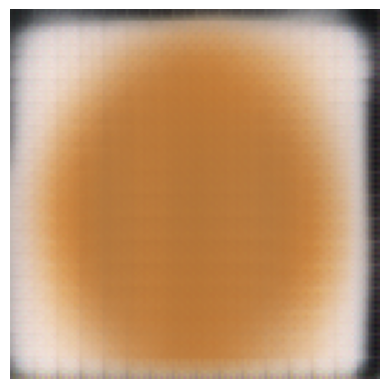

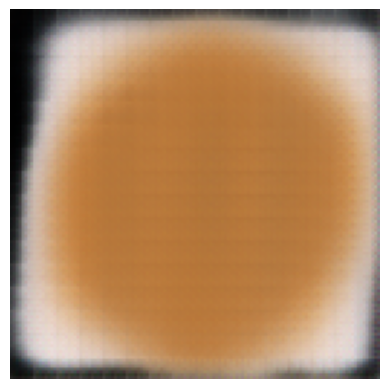

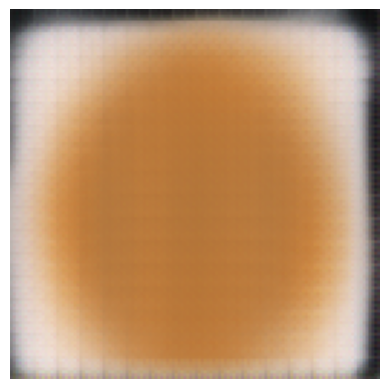

In [25]:
for img_path in ['car_wheel.jpg','america.png','pizza.png','india.png']:
  processed_image = process_image(img_path,recurrent_model)

  if processed_image:
      processed_image.save(f"output_{img_path}") # Save the processed image
      plt.imshow(processed_image)
      plt.axis('off')
      plt.show()